## LightGBM performs slightly better than Random Forest (AVG score: 0.533 vs 0.523), but it is much faster than Random Forest (30min vs 1h16min).


The feature selection notebook does a filter followed by a wrapper. It's capable of doing the filter on more than one file. The variable files are called vars1.csv, vars2.csv ...

The filter runs separately on each vars file and keeps the top num_filter variables from each file. If there are more than one vars files we'll again select the top num_filter variables across all the vars.csv files.

If balance = 0 the entire files are used. If balance != 0 then balance is the ratio of goods to bads retained for the rest of the feature selection. We keep all the rare class (bads) and downsample the goods. 

BUT RIGHT NOW I'VE GOT A BUG SOMEWHERE: balance !=0 doesn't work when num_files > 1. I've got an index problem.

So you can run with multiple variables files only when balance=0, or you can run with only one variable file and set balance how you like.

In [1]:
# load libraries
# %pip install mlxtend

import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import datetime as dt
import gc
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
%matplotlib inline
start_time = dt.datetime.now()

In [2]:
# set some parameters
num_files = 3
num_filter = 100
num_wrapper = 30
# keep balance = 0 when num_files > 1 until I figure out this bug. Maybe somebody else can figure it out.
balance = 0
detect_rate = .03
index_name = 'record'
y_name = 'fraud_label'
good_label = 0
bad_label = 1

## Run a filter on all the files

In [3]:
%%time
for i in range(num_files):
    file_name = "vars"+str(i+1)+'.csv'
    df = pd.read_csv(file_name)
    print('work on file ', file_name)
    df = df[df[index_name] <= 833508] # remove the last two months as the out-of-time data (OOT)
    df = df[df[index_name] >= 38512] # remove the first 2 weeks of records since their variables aren't well formed
    df['RANDOM'] = np.random.ranf(len(df)) # add a random number variable to make sure it doesn't come up as important
    goods = df[df[y_name] == good_label]
    bads = df[df[y_name] == bad_label]
    del df # don't need this file anymore
    num_goods = len(goods)
    num_bads = len(bads)
    num_vars = len(bads.columns)-2
    if(balance != 0):
        if(i == 0):
            num_goods_desired = int(min(num_goods,num_bads*balance))
            goods = goods.sample(n=num_goods_desired,random_state=1)
            goods_keep = list(goods.index)
            goods_keep.sort()
    
        if(i > 0):
            goods.set_index(index_name, inplace=True)
            goods.sort_index(inplace=True)
            goods = goods.iloc[goods_keep] # THERE'S SOMETHING WRONG HERE AND I CAN'T FIGURE IT OUT
            
    df_sampled = pd.concat([goods,bads])
    df_sampled.set_index(index_name, inplace=True)
    df_sampled.sort_index(inplace=True)
    if(i == 0): # if first time through need to initialize some stuff
        Y = pd.DataFrame(df_sampled[y_name], index=df_sampled.index)
        filter_score = pd.DataFrame(np.zeros((num_vars+1,2)))
        filter_score.columns = ['variable','score']   
        j = 0
        for column in df_sampled:
            filter_score.loc[j,'variable'] = column
            filter_score.loc[j,'score'] = sps.ks_2samp(goods[column],bads[column])[0]
            j = j+1
            
        filter_score.sort_values(by=['score'], ascending=False, inplace=True)
        vars_keep = list(filter_score['variable'][1:num_filter+1])
        print(filter_score.head(num_filter))
        df_top = df_sampled.filter(vars_keep, axis=1)
            
    if(i > 0): # if more than one variable file we use this loop
        new = pd.DataFrame(np.zeros((num_vars+1,2)))
        new.columns = ['variable','score']   
        j = 0
        for column in df_sampled:
            new.loc[j,'variable'] = column
            new.loc[j,'score'] = sps.ks_2samp(goods[column],bads[column])[0]
            j = j+1
        
        new.sort_values(by=['score'], ascending=False, inplace=True)
        vars_keep = list(new['variable'][1:num_filter+1])
        print(new.head(num_filter))
        data_new_top = df_sampled.filter(vars_keep, axis=1)
        df_top = pd.concat([df_top,data_new_top], axis=1)
        filter_score = pd.concat([filter_score,new])
    
    del goods # delete these before starting the next file, if any
    del bads
    gc.collect()

work on file  vars1.csv
                          variable     score
9                      fraud_label  1.000000
42               address_day_since  0.334096
70           fulladdress_day_since  0.333210
48                address_count_30  0.332725
76            fulladdress_count_30  0.332032
..                             ...       ...
201      ssn_name_app_age_count_14  0.201184
109  fulladdress_homephone_count_7  0.199751
59               homephone_count_3  0.194923
253         name_dob_count_0_by_14  0.194791
60               homephone_count_7  0.194198

[100 rows x 2 columns]
work on file  vars2.csv
                                             variable     score
501                                       fraud_label  1.000000
38   fulladdress_unique_count_for_ssn_name_app_age_30  0.314401
39   fulladdress_unique_count_for_ssn_name_app_age_60  0.311215
37   fulladdress_unique_count_for_ssn_name_app_age_14  0.287815
21           fulladdress_unique_count_for_ssn_name_60  0.286665
..  

In [4]:
filter_score.sort_values(by=['score'], ascending=False, inplace=True)

In [5]:
filter_score.head(33)

,variable,score
9,fraud_label,1.000000
332,fraud_label,1.000000
501,fraud_label,1.000000
42,address_day_since,0.334096
70,fulladdress_day_since,0.333210
48,address_count_30,0.332725
76,fulladdress_count_30,0.332032
47,address_count_14,0.322252
75,fulladdress_count_14,0.321756
38,fulladdress_unique_count_for_ssn_name_app_age_30,0.314401


In [6]:
filter_score.tail(10)

,variable,score
44,ssn_name_unique_count_for_ssn_1,0.0
301,ssn_name_app_age_unique_count_for_ssn_lastname_60,0.0
193,fulladdress_dob_unique_count_for_fulladdress_14,0.0
400,ssn_zip5_unique_count_for_ssn_1,0.0
401,ssn_zip5_unique_count_for_ssn_3,0.0
402,ssn_zip5_unique_count_for_ssn_7,0.0
477,ssn_zip3_unique_count_for_ssn_60,0.0
476,ssn_zip3_unique_count_for_ssn_30,0.0
475,ssn_zip3_unique_count_for_ssn_14,0.0
167,ssn_fulladdress_unique_count_for_ssn_zip3_14,0.0


In [7]:
filter_score.shape

(1338, 2)

In [8]:
filter_score.sort_values(by=['score'], ascending=False, inplace=True)
vars_keep = list(filter_score['variable'][num_files:num_filter+3])
print(i,' vars_keep:',vars_keep)

2  vars_keep: ['address_day_since', 'fulladdress_day_since', 'address_count_30', 'fulladdress_count_30', 'address_count_14', 'fulladdress_count_14', 'fulladdress_unique_count_for_ssn_name_app_age_30', 'fulladdress_unique_count_for_ssn_name_app_age_60', 'address_count_7', 'fulladdress_count_7', 'address_count_0_by_30', 'fulladdress_count_0_by_30', 'fulladdress_unique_count_for_dob_homephone_60', 'fulladdress_unique_count_for_ssn_name_app_age_14', 'fulladdress_unique_count_for_ssn_name_60', 'fulladdress_unique_count_for_ssn_lastname_60', 'fulladdress_unique_count_for_ssn_60', 'fulladdress_unique_count_for_ssn_zip5_60', 'fulladdress_unique_count_for_ssn_zip3_60', 'fulladdress_unique_count_for_ssn_fulladdress_60', 'fulladdress_unique_count_for_ssn_name_dob_60', 'fulladdress_unique_count_for_name_fulladdress_60', 'fulladdress_unique_count_for_name_dob_60', 'fulladdress_unique_count_for_fulladdress_dob_60', 'fulladdress_unique_count_for_dob_homephone_30', 'fulladdress_unique_count_for_ssn_na

In [9]:
df_keep = df_top.filter(vars_keep, axis=1)
df_keep.head()

,address_day_since,fulladdress_day_since,address_count_30,fulladdress_count_30,address_count_14,fulladdress_count_14,fulladdress_unique_count_for_ssn_name_app_age_30,fulladdress_unique_count_for_ssn_name_app_age_60,address_count_7,fulladdress_count_7,...,fulladdress_count_0_by_3,address_count_0_by_3,fulladdress_homephone_day_since,fulladdress_homephone_count_30,ssn_dob_day_since,ssn_dob_count_30,name_dob_day_since,name_dob_count_30,ssn_day_since,ssn_count_30
record,,,,,,,,,,,,,,,,,,,,,
38512,365.0,365.0,1,1,1,1,1,1,1,1,...,3.0,3.0,365.0,1,365.0,1,365.0,1,365.0,1
38513,365.0,365.0,1,1,1,1,1,1,1,1,...,3.0,3.0,365.0,1,365.0,1,365.0,1,365.0,1
38514,365.0,365.0,1,1,1,1,1,1,1,1,...,3.0,3.0,365.0,1,365.0,1,365.0,1,365.0,1
38515,365.0,365.0,1,1,1,1,1,1,1,1,...,3.0,3.0,365.0,1,365.0,1,365.0,1,365.0,1
38516,365.0,365.0,1,1,1,1,1,1,1,1,...,3.0,3.0,365.0,1,365.0,1,365.0,1,365.0,1


In [10]:
df_keep = df_top.filter(vars_keep, axis=1)
df_keep.head()

,address_day_since,fulladdress_day_since,address_count_30,fulladdress_count_30,address_count_14,fulladdress_count_14,fulladdress_unique_count_for_ssn_name_app_age_30,fulladdress_unique_count_for_ssn_name_app_age_60,address_count_7,fulladdress_count_7,...,fulladdress_count_0_by_3,address_count_0_by_3,fulladdress_homephone_day_since,fulladdress_homephone_count_30,ssn_dob_day_since,ssn_dob_count_30,name_dob_day_since,name_dob_count_30,ssn_day_since,ssn_count_30
record,,,,,,,,,,,,,,,,,,,,,
38512,365.0,365.0,1,1,1,1,1,1,1,1,...,3.0,3.0,365.0,1,365.0,1,365.0,1,365.0,1
38513,365.0,365.0,1,1,1,1,1,1,1,1,...,3.0,3.0,365.0,1,365.0,1,365.0,1,365.0,1
38514,365.0,365.0,1,1,1,1,1,1,1,1,...,3.0,3.0,365.0,1,365.0,1,365.0,1,365.0,1
38515,365.0,365.0,1,1,1,1,1,1,1,1,...,3.0,3.0,365.0,1,365.0,1,365.0,1,365.0,1
38516,365.0,365.0,1,1,1,1,1,1,1,1,...,3.0,3.0,365.0,1,365.0,1,365.0,1,365.0,1


In [11]:
df_keep.shape

(794997, 100)

In [12]:
Y.head()

,fraud_label
record,
38512,0
38513,0
38514,0
38515,0
38516,0


In [13]:
Y = Y.values
X = df_keep

In [14]:
print('time to here:', dt.datetime.now() - start_time)

time to here: 0:06:07.985626


In [15]:
print(X.shape,Y.shape)

(794997, 100) (794997, 1)


In [16]:
# I'd like to define a scoring for the wrapper that's KS, but I haven't gotten around to this yet.
# def KSscore(classifier, x,y)
#     goods = 

In [17]:
def fdr(classifier, x, y, cutoff=detect_rate):
# Calculates FDR score for the given classifier on dataset x and y with cutoff value
# get the probability list from the given classifier
    return fdr_prob(y, classifier.predict_proba(x), cutoff)
def fdr_prob(y, y_prob, cutoff=detect_rate):
    if len(y_prob.shape) != 1:    # sometimes the proba list can contain many columns, one for each category
        y_prob = y_prob[:, -1:]   # only the last one (fraud_label==1) is used here.
    num_fraud = len(y[y == 1])    # count the total nunber of frauds   
# sort the proba list from high to low while retain the true (not predicted) fraud label
    sorted_prob = np.asarray(sorted(zip(y_prob, y), key=lambda x: x[0], reverse=True))
    cutoff_bin = sorted_prob[0:int(len(y) * cutoff), 1:]  # 3% cutoff
# return the FDR score (#fraud_in_cutoff / #total_fraud)
    return len(cutoff_bin[cutoff_bin == 1]) / num_fraud   

In [18]:
%%time
# If you're doing forward selection it's enough to stop at num_wrapper variables. 
# If you're doing backward selection you need to go through all the variables to get 
# a sorted list of num_wrapper variables.
nfeatures = len(X.columns)
clf = LGBMClassifier(n_estimators=5, n_jobs=-1) # simple, fast nonlinear model for the wrapper
sfs = SFS(clf,k_features=num_wrapper,forward=True,verbose=2,scoring=fdr,cv=2,n_jobs=-1) # forward selection
# sfs = SFS(clf,k_features=1,forward=False,verbose=2,scoring=fdr,cv=2,n_jobs=-1) # backward selection
sfs.fit(X,Y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   44.9s finished

[2022-02-27 18:39:39] Features: 1/30 -- score: 0.35425735678216963[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:   49.3s finished

[2022-02-27 18:40:29] Features: 2/30 -- score: 0.5155841894480238[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done  98 out of  98 | elapsed:   51.2s finished

[2022-02-27 18:41:20] Features: 3/30 -- score: 0.5220268152533519[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done  97 

CPU times: user 3min 36s, sys: 9min 38s, total: 13min 15s
Wall time: 32min 27s



[2022-02-27 19:11:20] Features: 30/30 -- score: 0.5331708166463521

SequentialFeatureSelector(cv=2, estimator=LGBMClassifier(n_estimators=5),
                          k_features=30, n_jobs=-1,
                          scoring=<function fdr at 0x7f8dfb0443a0>, verbose=2)

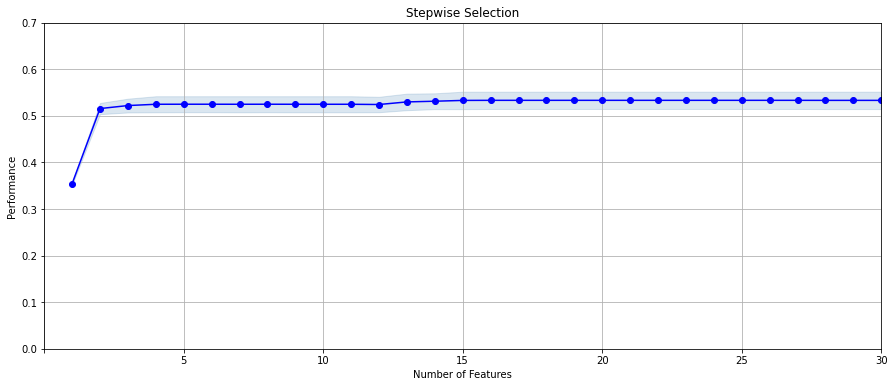

In [19]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
fig1 = plot_sfs(sfs.get_metric_dict(),kind='std_dev', figsize=(15, 6))
plt.xticks(np.arange(0, len(X.columns), step=5))
plt.ylim([0., .7])
plt.xlim(0,num_wrapper)
plt.title('Stepwise Selection')
plt.grid()
plt.savefig('FS_fdr.png')
plt.show()

In [20]:
vars_FS = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
vars_FS

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(3,)","[0.351732543966568, 0.3567821695977712]",0.354257,"(fulladdress_count_30,)",0.010863,0.002525,0.002525
2,"(3, 95)","[0.5035695629461954, 0.527598815949852]",0.515584,"(fulladdress_count_30, ssn_dob_count_30)",0.051695,0.012015,0.012015
3,"(3, 12, 95)","[0.5072261884032736, 0.5368274421034303]",0.522027,"(fulladdress_count_30, fulladdress_unique_coun...",0.063682,0.014801,0.014801
4,"(2, 3, 12, 95)","[0.5075744384468048, 0.5420511927563991]",0.524813,"(address_count_30, fulladdress_count_30, fulla...",0.074171,0.017238,0.017238
5,"(2, 3, 12, 20, 95)","[0.5077485634685704, 0.5420511927563991]",0.5249,"(address_count_30, fulladdress_count_30, fulla...",0.073796,0.017151,0.017151
6,"(2, 3, 12, 20, 22, 95)","[0.5077485634685704, 0.5420511927563991]",0.5249,"(address_count_30, fulladdress_count_30, fulla...",0.073796,0.017151,0.017151
7,"(2, 3, 12, 20, 22, 95, 97)","[0.5075744384468048, 0.5420511927563991]",0.524813,"(address_count_30, fulladdress_count_30, fulla...",0.074171,0.017238,0.017238
8,"(2, 3, 12, 20, 22, 32, 95, 97)","[0.5077485634685704, 0.5420511927563991]",0.5249,"(address_count_30, fulladdress_count_30, fulla...",0.073796,0.017151,0.017151
9,"(2, 3, 12, 20, 22, 24, 32, 95, 97)","[0.5075744384468048, 0.5420511927563991]",0.524813,"(address_count_30, fulladdress_count_30, fulla...",0.074171,0.017238,0.017238
10,"(2, 3, 12, 20, 22, 24, 32, 35, 95, 97)","[0.5075744384468048, 0.5420511927563991]",0.524813,"(address_count_30, fulladdress_count_30, fulla...",0.074171,0.017238,0.017238


In [21]:
vars_FS = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
vars_FS

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(3,)","[0.351732543966568, 0.3567821695977712]",0.354257,"(fulladdress_count_30,)",0.010863,0.002525,0.002525
2,"(3, 95)","[0.5035695629461954, 0.527598815949852]",0.515584,"(fulladdress_count_30, ssn_dob_count_30)",0.051695,0.012015,0.012015
3,"(3, 12, 95)","[0.5072261884032736, 0.5368274421034303]",0.522027,"(fulladdress_count_30, fulladdress_unique_coun...",0.063682,0.014801,0.014801
4,"(2, 3, 12, 95)","[0.5075744384468048, 0.5420511927563991]",0.524813,"(address_count_30, fulladdress_count_30, fulla...",0.074171,0.017238,0.017238
5,"(2, 3, 12, 20, 95)","[0.5077485634685704, 0.5420511927563991]",0.5249,"(address_count_30, fulladdress_count_30, fulla...",0.073796,0.017151,0.017151
6,"(2, 3, 12, 20, 22, 95)","[0.5077485634685704, 0.5420511927563991]",0.5249,"(address_count_30, fulladdress_count_30, fulla...",0.073796,0.017151,0.017151
7,"(2, 3, 12, 20, 22, 95, 97)","[0.5075744384468048, 0.5420511927563991]",0.524813,"(address_count_30, fulladdress_count_30, fulla...",0.074171,0.017238,0.017238
8,"(2, 3, 12, 20, 22, 32, 95, 97)","[0.5077485634685704, 0.5420511927563991]",0.5249,"(address_count_30, fulladdress_count_30, fulla...",0.073796,0.017151,0.017151
9,"(2, 3, 12, 20, 22, 24, 32, 95, 97)","[0.5075744384468048, 0.5420511927563991]",0.524813,"(address_count_30, fulladdress_count_30, fulla...",0.074171,0.017238,0.017238
10,"(2, 3, 12, 20, 22, 24, 32, 35, 95, 97)","[0.5075744384468048, 0.5420511927563991]",0.524813,"(address_count_30, fulladdress_count_30, fulla...",0.074171,0.017238,0.017238


In [22]:
vars_final = list(vars_FS.loc[num_wrapper, 'feature_names'])
vars_final

['address_day_since',
 'fulladdress_day_since',
 'address_count_30',
 'fulladdress_count_30',
 'address_count_14',
 'fulladdress_count_14',
 'address_count_7',
 'fulladdress_count_7',
 'address_count_0_by_30',
 'fulladdress_count_0_by_30',
 'fulladdress_unique_count_for_dob_homephone_60',
 'fulladdress_unique_count_for_ssn_name_dob_60',
 'fulladdress_unique_count_for_name_dob_60',
 'fulladdress_unique_count_for_fulladdress_dob_60',
 'fulladdress_unique_count_for_dob_homephone_30',
 'address_count_0_by_14',
 'fulladdress_unique_count_for_ssn_name_dob_30',
 'fulladdress_count_0_by_14',
 'fulladdress_unique_count_for_name_dob_30',
 'fulladdress_unique_count_for_fulladdress_dob_30',
 'fulladdress_count_3',
 'address_count_3',
 'fulladdress_unique_count_for_ssn_name_dob_14',
 'fulladdress_unique_count_for_name_dob_7',
 'fulladdress_homephone_day_since',
 'fulladdress_homephone_count_30',
 'ssn_dob_day_since',
 'ssn_dob_count_30',
 'name_dob_day_since',
 'name_dob_count_30']

In [23]:
vars_FS.to_csv('VarsFS.csv', index=False)

In [24]:
sfs.subsets_

{1: {'feature_idx': (3,),
  'cv_scores': array([0.35173254, 0.35678217]),
  'avg_score': 0.35425735678216963,
  'feature_names': ('fulladdress_count_30',)},
 2: {'feature_idx': (3, 95),
  'cv_scores': array([0.50356956, 0.52759882]),
  'avg_score': 0.5155841894480238,
  'feature_names': ('fulladdress_count_30', 'ssn_dob_count_30')},
 3: {'feature_idx': (3, 12, 95),
  'cv_scores': array([0.50722619, 0.53682744]),
  'avg_score': 0.5220268152533519,
  'feature_names': ('fulladdress_count_30',
   'fulladdress_unique_count_for_dob_homephone_60',
   'ssn_dob_count_30')},
 4: {'feature_idx': (2, 3, 12, 95),
  'cv_scores': array([0.50757444, 0.54205119]),
  'avg_score': 0.524812815601602,
  'feature_names': ('address_count_30',
   'fulladdress_count_30',
   'fulladdress_unique_count_for_dob_homephone_60',
   'ssn_dob_count_30')},
 5: {'feature_idx': (2, 3, 12, 20, 95),
  'cv_scores': array([0.50774856, 0.54205119]),
  'avg_score': 0.5248998781124847,
  'feature_names': ('address_count_30',
   

In [25]:
vars_final.append('index_name')
vars_final.append('y_name')
vars_final

['address_day_since',
 'fulladdress_day_since',
 'address_count_30',
 'fulladdress_count_30',
 'address_count_14',
 'fulladdress_count_14',
 'address_count_7',
 'fulladdress_count_7',
 'address_count_0_by_30',
 'fulladdress_count_0_by_30',
 'fulladdress_unique_count_for_dob_homephone_60',
 'fulladdress_unique_count_for_ssn_name_dob_60',
 'fulladdress_unique_count_for_name_dob_60',
 'fulladdress_unique_count_for_fulladdress_dob_60',
 'fulladdress_unique_count_for_dob_homephone_30',
 'address_count_0_by_14',
 'fulladdress_unique_count_for_ssn_name_dob_30',
 'fulladdress_count_0_by_14',
 'fulladdress_unique_count_for_name_dob_30',
 'fulladdress_unique_count_for_fulladdress_dob_30',
 'fulladdress_count_3',
 'address_count_3',
 'fulladdress_unique_count_for_ssn_name_dob_14',
 'fulladdress_unique_count_for_name_dob_7',
 'fulladdress_homephone_day_since',
 'fulladdress_homephone_count_30',
 'ssn_dob_day_since',
 'ssn_dob_count_30',
 'name_dob_day_since',
 'name_dob_count_30',
 'index_name',
 

In [26]:
X_final = df_keep.filter(vars_final, axis=1)
X_final.shape

(794997, 30)

In [27]:
X_final.to_csv('vars_final.csv', index=False)